In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats
import sys
sys.path.append('/Users/Alexander/custom_pymodules')
from brownian_dynamics_1d import brownian_dynamics_1d
import kl_divergence as kl_div

In [2]:
font={'fontname':'Times New Roman'}
plt.rcParams.update({'font.size':12})
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
def cumulative(p):
    """
    Caluculate a cumulative mass function (CMF) given a probability mass function (PMF).
    
    Input: p - a 1XN dimensional array whose elements sum to 1, representing a
               PMF arranged in order by the discrete random variable.
    Output: the CMF of p
    """
    out = []
    for n in range(len(p)):
        val = np.sum(p[:n])
        out.append(val)
    return out

In [4]:
def inv_cumulative(num,support,cp):
    """
    Sample a discrete distribution (probability mass function (PMF)) given the cumulative
    mass function (CMF) of the distribution. 
    
    Input: num - a (pseudo)random number between 0 and 1. Use numpy.random.random()
           support - the discrete support of the desired distribution
           cp - the CMF of the desired distribution
    Output: an element of the support, distributed according to the PMF used to calculate 
            the supplied CMF.
    """
    index = np.argmin(abs(np.array(cp)-num))
    return support[index]

### Using the supplied brownian_dynamics_1d module, we define two potential energy functions using sums of three Gaussian functions for each, defined by $V_0$ and $V_1$ in the following manner shown for $V_0$:
$$V_{Potential,0}(x)=\sum_{i=1}^{3}{a_{i}\mathrm{e}^{{b_{i}(x-c_{i})^{2}}}}$$

$$
V_0=
\begin{bmatrix}
    a_{1} & b_{1} & c_{1} \\
    a_{2} & b_{2} & c_{2} \\
    a_{3} & b_{3} & c_{3}
\end{bmatrix}
$$
### These potential energy functions are then evaluated over the discretized range $\{0 \leq x \leq 359:x\in\mathbb{N}\}$ (note the bin size of $1^{\circ}$) and the probability of $x$ is given according to the Boltzmann distribution: 
$$p_{0}(x)=\frac{\mathrm{e}^{-\beta V_{Potential,0}(x)}}{\sum_{x=0}^{359}\mathrm{e}^{-\beta V_{Potential,0}(x)}}$$

$$\beta=(k_{B}T)^{-1}$$
### We can then calculate an approximate theoretical Kullback-Leibler divergence as follows:
$$KL_{Theoretical}=\sum_{x=0}^{359}{p_{1}(x)\ln{\frac{p_{1}(x)}{p_{0}(x)}}}$$

In [5]:
V_0 = np.array([[-.1, -.001, 90], \
                [-.4, -.001, 180], \
                [-1, -.001, 270]])
V_1 = np.array([[-1, -.0001, 80], \
                [-.2, -.001, 170], \
                [-.1, -.001, 280]])
brownian_ref = brownian_dynamics_1d(V=V_0)
brownian_test = brownian_dynamics_1d(V=V_1)
k_B = 1
T = 1
x = np.mgrid[0:360:1]
V_0a = brownian_ref.potential(x)
V_1a = brownian_test.potential(x)
p_0 = np.exp(-V_0a/(k_B*T))/np.sum(np.exp(-V_0a/(k_B*T)))
p_1 = np.exp(-V_1a/(k_B*T))/np.sum(np.exp(-V_1a/(k_B*T)))
cp_0 = cumulative(p_0)
cp_1 = cumulative(p_1)
kl_div_theoretical = np.sum(p_1*np.log(p_1/p_0))

In [6]:
kl_div_theoretical

0.15684008837542596

### Plot of theoretical probability density functions

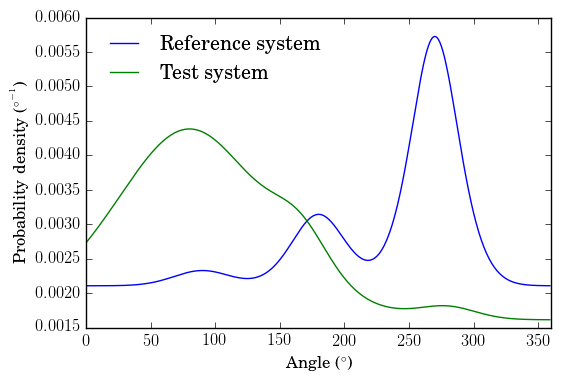

In [7]:
plt.plot(x,p_0,label=r'Reference system')
plt.plot(x,p_1,label=r'Test system')
plt.xlim(0,360)
plt.xlabel('Angle ($^{\circ}$)')
plt.ylabel('Probability density ($^{\circ^{-1}}$)')
plt.legend(loc=0,frameon=False)
plt.show()

### Plot of Kullback-Leibler divergence terms

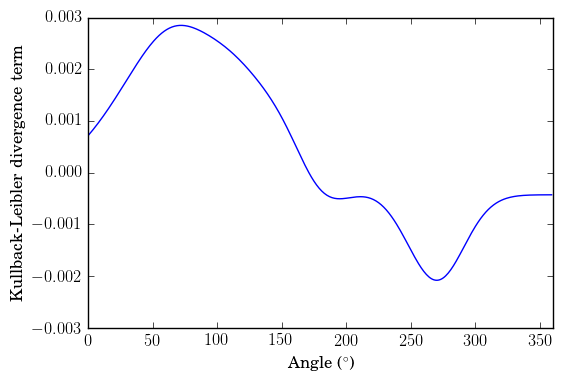

In [8]:
plt.plot(x,(p_1*np.log(p_1/p_0)))
plt.xlim(0,360)
plt.xlabel('Angle ($^{\circ}$)')
plt.ylabel('Kullback-Leibler divergence term')
plt.show()

### Plot of cumulative density functions

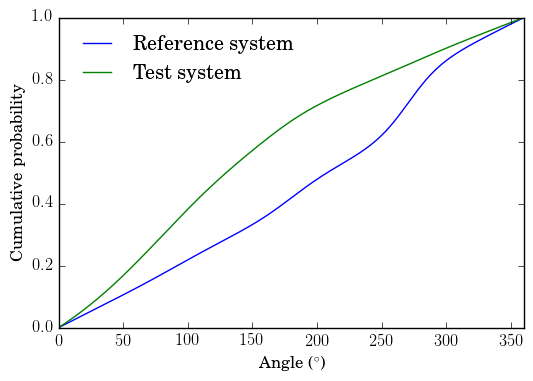

In [9]:
plt.plot(x,cp_0,label=r'Reference system')
plt.plot(x,cp_1,label=r'Test system')
plt.xlim(0,360)
plt.xlabel('Angle ($^{\circ}$)')
plt.ylabel('Cumulative probability')
plt.legend(loc=0,frameon=False)
plt.show()

### Using the 'inv\_cumulative' function defined above, we sample from both probability mass functions $p_{0}$ and $p_{1}$

In [10]:
ref_set = []
t = 10000
n = 0
while n < 200:
    x = np.mgrid[0:360:1]
    x_0 = inv_cumulative(np.random.random(),x,cp_0)
    brownian_ref = brownian_dynamics_1d(V=V_0)
    brownian_ref.integrate_brownian(x_0, t, 1)
    ref_set.append(brownian_ref.X_t)
    n += 1

In [11]:
test_set = []
t = 10000
n = 0
while n < 200:
    x = np.mgrid[0:360:1]
    x_0 = inv_cumulative(np.random.random(),x,cp_1)
    brownian_test = brownian_dynamics_1d(V=V_1)
    brownian_test.integrate_brownian(x_0, t, 1)
    test_set.append(brownian_test.X_t)
    n += 1

### Plot both theoretical PDFs and histograms of the samples

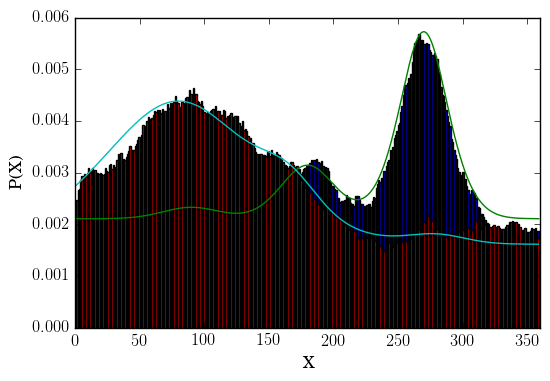

In [12]:
plt.hist(np.vstack(ref_set),range=[0,360],bins=359,normed=True)
brownian_ref.plot_probability()
plt.hist(np.vstack(test_set),range=[0,360],bins=359,normed=True)
brownian_test.plot_probability()
plt.show()

### Calculate the sample KL divergence

In [13]:
kl = kl_div.local_kl_divergence()
kl.dih_ref = [['RES1',ref_set]]
kl.dih_test = [['RES1',test_set]]
kl_divergence, raw_kl = kl.kl_div(binrange=[0,360],return_raw=True)
raw_kl = raw_kl[0]

In [14]:
kl_divergence

[['RES1', 0.10143643146399933]]

### Finally, we calculate a bootstrap distribution of KL divergences from the samples and determine a $p$ value representing the probability that the sample KL divergence between the two distributions was produced by identical distributions. If $p<.05$, the final KL divergence, $H$, is reported with the mean bootstrap KL divergence $H_{0}$ subtracted. 

In [15]:
kl_div_H0, bootstrap = kl.kl_div_H0(binrange=[0,360])
bootstrap = np.array(bootstrap[0])
kde = sp.stats.kde.gaussian_kde(bootstrap)
x = np.mgrid[0:max(bootstrap):max(bootstrap)/100.0]

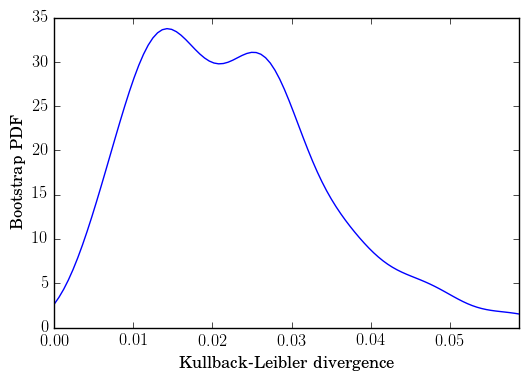

In [16]:
plt.plot(x,kde(x))
plt.scatter(raw_kl,kde(raw_kl))
plt.ylim(0,round(kde(x).max())+1)
plt.xlim(0,x.max())
plt.xlabel(r'Kullback-Leibler divergence')
plt.ylabel(r'Bootstrap PDF')
plt.show()

In [17]:
p_value = (bootstrap[bootstrap > raw_kl].sum())/float(bootstrap.sum())
print 'p-value: ', p_value 

p-value:  0.0


In [18]:
print 'Raw KL divergence: ', raw_kl, '; H_0: ', kl_div_H0[0]

Raw KL divergence:  0.125878344015 ; H_0:  0.0224529889588
